In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

In [ ]:
# df has 4059 features and 158 samples
df= pd.read_csv("data/trans_omic_untargeted/prs_feat_table_pos.csv")
df_feat_to_samples = df[[col for col in df.columns if col.startswith('2') or col=='namecustom']]
# print(df_feat_to_samples.head())

# df meta has 643 samples (decreased to 158)
df_meta = pd.read_csv("data/trans_omic_untargeted/meta_data.csv")
df_meta = df_meta[['sample_id', 'is_bad']]
df_meta = df_meta[df_meta['sample_id'].isin(df.columns)] #158
# print(df_meta.head())

# merge_df
df_transposed = df_feat_to_samples.set_index('namecustom').T
df_comb = df_meta.merge(
    right=df_transposed, 
    left_on='sample_id', 
    right_index=True, 
    how='left')
df_comb.to_csv("features_meta_combined.csv")
print(df_comb.head())

# group data
bad = df_comb[df_comb["is_bad"]==1]
good = df_comb[df_comb["is_bad"]==0]

              namecustom         mz      mzmin      mzmax          rt  \
0     M70.065243T44.3972  70.065243  70.064623  70.065658   44.397226   
1     M70.162528T573.481  70.162528  70.158316  70.162604  573.480957   
2  M70.568609T582.7159_1  70.568609  70.568346  70.568643  582.715912   
3  M70.718387T490.9966_1  70.718387  70.711484  70.718776  490.996552   
4  M70.819398T582.6421_2  70.819398  70.814585  70.823641  582.642090   

        rtmin       rtmax  npeaks    .  \
0   24.481733   62.890923     220  158   
1  572.720947  591.545166     113  113   
2  582.141541  598.514526     160  158   
3  490.394043  499.445557     168  157   
4  576.409241  599.342285     163  158   

                                             peakidx  ...  \
0  3550,31948,59771,90859,119454,147953,178537,21...  ...   
1  16344,46174,105686,134206,230064,288787,389725...  ...   
2  17383,46986,78580,106534,135148,163736,201907,...  ...   
3  12418,42291,72716,101307,129904,158816,195644,...  ...   
4  

In [3]:
# features = [col for col in df_comb.columns if col.startswith('M')]
# from scipy.stats import bartlett
# lev_p = []
# for feature in features:
#     stat, p = bartlett(bad[feature], good[feature])
#     # print(f"{feature}: Levene's test p={p}")
#     lev_p.append(p)

# print("Unequal var:", len(list(filter(lambda x: x<0.05, lev_p))))
# print("Equal var:", len(list(filter(lambda x: x>=0.05, lev_p))))

In [4]:
# t-test for each feature
from scipy.stats import bartlett

features = [col for col in df_comb.columns if col.startswith('M')]
log_2_FC = []
p_values = []
stats = []
for feature in features:
    _, bart_p = bartlett(bad[feature], good[feature])
    bart = bart_p >= 0.05
    t_stat, p_val = ttest_ind(bad[feature], good[feature], equal_var=bart)
    
    stats.append(t_stat)
    p_values.append(p_val)
    log_2_FC.append(np.log2(good[feature].mean()) - np.log2(bad[feature].mean()))

# Correction - Bonferroni / Benjamini-Hochberg
adjusted_p_bon = multipletests(p_values, method='bonferroni')[1]
adjusted_p_bh_fdr = multipletests(p_values, method='fdr_bh')[1]

# Results
results = pd.DataFrame({
    "Feature": features, 
    "T-values": stats, 
    "P-values": p_values,
    "Adjusted p-values (bon)": adjusted_p_bon,
    "Adjusted p-values (bh_fdr)": adjusted_p_bh_fdr,
    "mz": df["mz"] 
    })
significant_res_bon = results[results["Adjusted p-values (bon)"] < 0.05]
significant_res_bh = results[results["Adjusted p-values (bh_fdr)"] < 0.05]
results.to_csv("t_test_results_bart.csv")
significant_res_bon.to_csv("t_test_significant_results_bon_bart.csv")
significant_res_bh.to_csv("t_test_significant_results_bh_bart.csv")

281


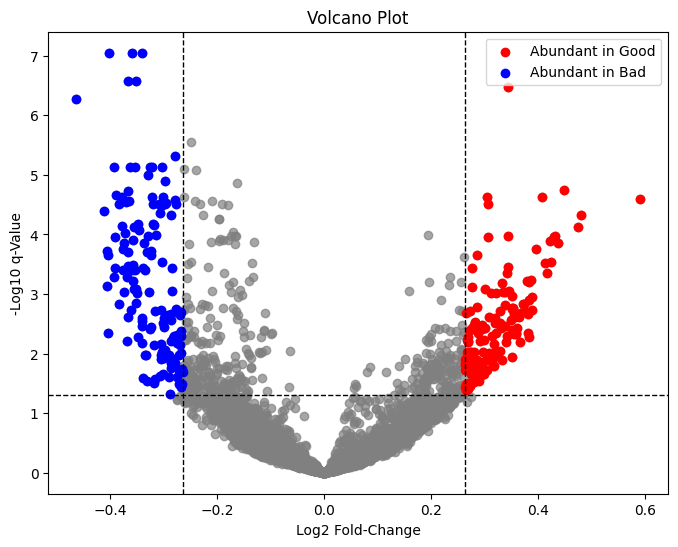

In [ ]:
# Visualise volcano plot
import matplotlib.pyplot as plt


plot_data = pd.DataFrame({
    "log2FC": log_2_FC,
    "adjusted p-values": results["Adjusted p-values (bh_fdr)"]
    # "adjusted p-values": results["Adjusted p-values (bon)"]
})
plot_data["-log10(p-value)"] = -np.log10(plot_data["adjusted p-values"])
fc_thresh = np.log2(1.2) # FC of 1.2
p_thresh = 0.05

plt.figure(figsize=(8, 6))
plt.scatter(plot_data["log2FC"], plot_data["-log10(p-value)"], color="gray", alpha=0.7)

significant_up = plot_data[(plot_data["log2FC"] > fc_thresh) & (plot_data["adjusted p-values"] < p_thresh)]
significant_down = plot_data[(plot_data["log2FC"] < -fc_thresh) & (plot_data["adjusted p-values"] < p_thresh)]
print(len(significant_up)+len(significant_down))
plt.scatter(significant_up["log2FC"], significant_up["-log10(p-value)"], color="red", label="Abundant in Good")
plt.scatter(significant_down["log2FC"], significant_down["-log10(p-value)"], color="blue", label="Abundant in Bad")

plt.axhline(-np.log10(p_thresh), color="black", linestyle="--", linewidth=1)
plt.axvline(fc_thresh, color="black", linestyle="--", linewidth=1)
plt.axvline(-fc_thresh, color="black", linestyle="--", linewidth=1)

plt.title("Volcano Plot")
plt.xlabel("Log2 Fold-Change")
plt.ylabel("-Log10 q-Value")
plt.legend()
plt.show()

